# Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

raw_data = pd.read_csv('raw_merged.csv')


C:\Users\shery\AppData\Local\Temp\ipykernel_13380\2723244342.py:5: DtypeWarning: Columns (1,7,22,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('raw_merged.csv')


In [2]:
raw_data = raw_data.replace(['EX - Excellent'] , 'E - Excellent')
raw_data["case_created_date"] = raw_data["case_created_date"][:11]
raw_data["close_date"] = raw_data["close_date"][:11]
raw_data["last_case_update"] = raw_data["last_case_update"][:11]

#split data insto 70 train, 15 val, 15 test
train_data, temp_data = train_test_split(raw_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2164743, 32)
Validation data shape: (463874, 32)
Test data shape: (463874, 32)


In [3]:
print(train_data['overall_cond'].value_counts())
print('NA COUNTS: ', train_data.isna().sum())
print('num sam ids: ', train_data['sam_id'].nunique())


overall_cond
A - Average       1798955
G - Good           111181
E - Excellent       30844
VG - Very Good       7101
F - Fair              689
P - Poor               12
Name: count, dtype: int64
NA COUNTS:  Unnamed: 0                 0
over_5               1976368
year                       0
full_address               0
sam_id                     0
building_id                0
ward_id                    0
parcel_num                 0
case_created_date    2164735
last_case_update     2164735
case_enquiry_id        11893
targeted_deadline     303630
close_date           2164737
case_met_deadline      11900
case_status            11893
closure_reason         11893
case_title             11893
case_subject           11893
case_reason            11893
case_type              11893
case_department        11893
p_id                  191098
cm_id                 247421
gis_id                191320
landlord_name         191168
int_cond              608429
ext_cond              568442
overall_co

In [4]:
train_data.head()
train_data['overall_cond'].head()

411370     A - Average
1985085    A - Average
1482786    A - Average
2112011            NaN
495677     A - Average
Name: overall_cond, dtype: object

# Additional Column(s)

In [5]:
'''def check(cond):
        if cond == 'F - Fair' or cond == 'P - Poor':
            return 1
        else:
            return 0
train_data['prob_address'] = train_data['overall_cond'].apply(check)


print(train_data['overall_cond'].value_counts())
print(train_data['prob_address'].value_counts())'''

problematic_values = ['F - Fair', 'P - Poor']
train_data[['overall_cond','ext_cond','int_cond']] = train_data[['overall_cond','ext_cond','int_cond']].fillna('')

train_data['prob_address'] = (
    train_data['overall_cond'].str.strip().isin(problematic_values) |
    train_data['ext_cond'].str.strip().isin(problematic_values) |
    train_data['int_cond'].str.strip().isin(problematic_values)
).astype(int)
print(train_data['prob_address'].value_counts())

prob_address
0    2158905
1       5838
Name: count, dtype: int64


# TRAIN TEST SPLIT!!!

In [6]:
sample_size = 0.2
print("Taking smaller sample size for faster processing...")

#train_data_with_target = train_data[train_data["prob_address"].notna()].copy()

from sklearn.model_selection import train_test_split
_, train_data_sample = train_test_split(
    train_data, #split the train data again so that it is easier to test our feature engineering 
    test_size = sample_size, 
    random_state=42, 
    #stratify=train_data_with_target["prob_address"] 
)

print("Sampled training set shape: ", train_data_sample.shape)
print("Sampled prob distribution", train_data_sample["prob_address"].value_counts())



Taking smaller sample size for faster processing...
Sampled training set shape:  (432949, 33)
Sampled prob distribution prob_address
0    431805
1      1144
Name: count, dtype: int64


# Feature Engineering 

In [9]:
import numpy as np
import datetime 
from datetime import date
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD 
import pickle 

#feature engineering function
def create_features(dataset):

    #Feature 0: Fix Values 
    
    # Fill in Nans 
    print("filling in nans...")
    dataset["case_title"] = dataset["case_title"].fillna("").astype(str)
    dataset["case_subject"] = dataset["case_subject"].fillna("").astype(str)
    dataset["case_reason"] = dataset["case_reason"].fillna("").astype(str)
    dataset["over_5"] = dataset["over_5"].fillna("").astype(str)
    dataset["int_cond"] = dataset["int_cond"].fillna("").astype(str)
    dataset["ext_cond"] = dataset["ext_cond"].fillna("").astype(str)
    dataset["overall_cond"] = dataset["overall_cond"].fillna("").astype(str)
    dataset["bdrm_cond"] = dataset["bdrm_cond"].fillna("").astype(str)
    dataset["heat_type"] = dataset["heat_type"].fillna("").astype(str)
    dataset["ac_type"] = dataset["ac_type"].fillna("").astype(str)
    dataset["parcel_num"] = dataset["parcel_num"].astype(str)
    dataset["cm_id"] = dataset["cm_id"].astype(str)

    dataset["close_date"] = dataset["close_date"].fillna(date.today())
    dataset["close_date"] = dataset["close_date"].astype(str)
    
    # String -> Integer 
    dataset["year"] = dataset["year"].astype(int)

    # Standardize Values
    dataset["over_5"] = dataset["over_5"].replace(["N", "No"], "NO")
    dataset["over_5"] = dataset["over_5"].replace(["Y"], "YES")
    dataset["over_5"] = dataset["over_5"].replace(["nan"], "")
    
    #Feature 1: Text Features 
    print("Extracting text features...")
    dataset["case_reason_length"] = dataset["case_reason"].fillna('').astype(str).str.len()
    dataset['case_reason_word_count'] = dataset['case_reason'].fillna('').astype(str).str.split().str.len()

    dataset['case_title_length'] = dataset['case_title'].fillna('').astype(str).str.len()
    dataset['case_title_word_count'] = dataset['case_title'].fillna('').astype(str).str.split().str.len()

    dataset['case_type_length'] = dataset['case_type'].fillna('').astype(str).str.len()
    dataset['case_type_word_count'] = dataset['case_type'].fillna('').astype(str).str.split().str.len()

    #Feature 2: Time Based Features 
    print("doing time based features...")
    dataset['case_date'] = pd.to_datetime(dataset['case_created_date'], errors='coerce', infer_datetime_format=True)
    dataset['case_closing_date'] = pd.to_datetime(dataset['close_date'], errors='coerce', infer_datetime_format=True)

    #dataset['case_date'] = pd.to_datetime(dataset['case_created_date'], unit='s')
    dataset['case_year'] = dataset['case_date'].dt.year
    dataset['case_month'] = dataset['case_date'].dt.month
    dataset['case_day_of_week'] = dataset['case_date'].dt.dayofweek

    #dataset['case_closing_date'] = pd.to_datetime(dataset['close_date'])
    dataset['close_year'] = dataset['case_closing_date'].dt.year
    dataset['close_month'] = dataset['case_closing_date'].dt.month
    dataset['close_day_of_week'] = dataset['case_closing_date'].dt.dayofweek


    # Feature 3: Cyclical encoding for month and day of week
    print("Cyclical encoding for month and day...")
    dataset['created_month_sin'] = np.sin(2 * np.pi * dataset['case_month'] / 12)
    dataset['created_month_cos'] = np.cos(2 * np.pi * dataset['case_month'] / 12)
    dataset['created_dow_sin'] = np.sin(2 * np.pi * dataset['case_day_of_week'] / 7)
    dataset['created_dow_cos'] = np.cos(2 * np.pi * dataset['case_day_of_week'] / 7)

    dataset['closed_month_sin'] = np.sin(2 * np.pi * dataset['close_month'] / 12)
    dataset['closed_month_cos'] = np.cos(2 * np.pi * dataset['close_month'] / 12)
    dataset['closed_dow_sin'] = np.sin(2 * np.pi * dataset['close_day_of_week'] / 7)
    dataset['closed_dow_cos'] = np.cos(2 * np.pi * dataset['close_day_of_week'] / 7)

    # Feature 3.1: Length of case open
    dataset['case_open_days'] = (dataset['case_closing_date'] - dataset['case_date']).dt.days
    dataset["avg_resolution_time"] = dataset.groupby("full_address")["case_open_days"].transform("mean")

    # Feature 3.2: Num cases per address
    print("calculating cases per address per year...")
    cases_per_address_year = (
        dataset.groupby(["full_address", "year"])["case_enquiry_id"]
            .nunique()
            .reset_index(name="case_count")
        )

    dataset = dataset.merge(  # your base dataset of all addresses
        cases_per_address_year,
        on=["full_address", "year"],
        how="left"
    )

    # Feature 4: Severity Analysis
    print("performing sentiment intensity analysis...")
    sia = SentimentIntensityAnalyzer()
    dataset["case_reason_severity_score"] = dataset["case_reason"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
    dataset["case_title_severity_score"] = dataset["case_title"].apply(lambda x: sia.polarity_scores(str(x))["compound"])
    
    # Feature 5: TF-IDF
    print("doing tfidf on title and case reasons...")
    # For case reason: 
    case_reason_tfidf = TfidfVectorizer(
        max_features=2000,    # adjust based on memory / dataset size --> 4k 
        ngram_range=(1, 2),   # unigrams + bigrams
        stop_words='english',
        min_df=10,             
        max_df=0.8,
        sublinear_tf=True           
    )
    
    case_reason_tfidf_transformed = case_reason_tfidf.fit_transform(dataset['case_reason']) 

    # For case title 
    case_title_tfidf = TfidfVectorizer(
        max_features=3000,    # adjust based on memory / dataset size --> 4k 
        ngram_range=(1, 2),   # unigrams + bigrams
        stop_words='english',
        min_df=10,             
        max_df=0.8,
        sublinear_tf=True           
    )
    
    case_title_tfidf_transformed = case_title_tfidf.fit_transform(dataset['case_title']) 
    with open ('case_reason_tfidf.pkl', 'wb') as f:
        pickle.dump(case_reason_tfidf, f)
    with open ('case_title_tfidf.pkl', 'wb') as f:
        pickle.dump(case_title_tfidf, f)

    # Feature 5.1: SVD 
    print("truncate svd-ing...")
    svd = TruncatedSVD(n_components=5, random_state=42)
    case_reason_svd = svd.fit_transform(case_reason_tfidf_transformed)
    case_title_svd = svd.fit_transform(case_title_tfidf_transformed)

    for i in range(case_reason_svd.shape[1]):
        dataset[f'reason_tfidf_svd{i}'] = case_reason_svd[:,i]

    for i in range(case_title_svd.shape[1]):
        dataset[f'title_tfidf_svd{i}'] = case_title_svd[:,i]

    with open ('case_reason_svd.pkl', 'wb') as f:
        pickle.dump(case_reason_svd, f)
    with open ('case_title_svd.pkl', 'wb') as f:
        pickle.dump(case_title_svd, f)
        

    # Feature 6: Frequency of Cases
    print("finding frequency of cases...")
    dataset["years_with_cases"] = dataset.groupby("full_address")["year"].transform("nunique")
    dataset["total_case_count_address"] = dataset.groupby("full_address")["case_enquiry_id"].transform("count")
    dataset["avg_cases_per_year"] = dataset["total_case_count_address"] / dataset["years_with_cases"]

    # Feature 7: Escalation of Severity
    print("finding escalation of severity... ")
    '''
    year_counts = dataset.groupby(["full_address", "year"])["case_enquiry_id"].count()
    dataset["year_over_year_increase"] = year_counts.groupby(level=0).diff().fillna(0)
    ''' 
    # Feature 7: Escalation of Severity
    print("finding escalation of severity... ")
    counts_df = (
        dataset.groupby(["full_address", "year"], as_index=False)["case_enquiry_id"]
            .count()
            .rename(columns={"case_enquiry_id": "case_count"})
    )
    counts_df = counts_df.sort_values(["full_address", "year"])
    counts_df["year_over_year_increase"] = counts_df.groupby("full_address")["case_count"].diff().fillna(0)

    # Merge results back to dataset
    dataset = dataset.merge(counts_df[["full_address", "year", "case_count", "year_over_year_increase"]],
                            on=["full_address", "year"],
                            how="left")



    # Feature 8: Repeat closure failure / missed deadlines
    print("finding if metdeadline...")
    dataset['met_deadline'] = (dataset['case_met_deadline'] == "YES").astype(int)
    dataset['deadline_fail_rate'] = dataset.groupby("full_address")["met_deadline"].transform(lambda x: 1 - x.mean())

    # Feature 9: Condition Flags
    print("mapping conditions to scores ")
    condition_map = {
        "E - Excellent" : 1,
        "VG - Very Good" : 2,
        "G - Good" : 3,  
        "A - Average": 4,
        "F - Fair" : 5, 
        "P - Poor" : 6  
    }

    dataset["overall_cond_score"] = dataset["overall_cond"].map(condition_map).fillna(0)
    dataset["int_cond_score"] = dataset["int_cond"].map(condition_map).fillna(0)
    dataset["ext_cond_score"] = dataset["ext_cond"].map(condition_map).fillna(0)

    dataset["avg_overall_condition"] = dataset.groupby("full_address")["overall_cond_score"].transform("mean")
    dataset['case_date'] = dataset['case_date'].astype('int64') // 10**9
    dataset['case_closing_date'] = dataset['case_closing_date'].astype('int64') // 10**9

    #log transformations
    print("doing log transformations...")
    dataset['log_case_reason_length'] = np.log1p(dataset['case_reason_length'])
    dataset['log_case_reason_word_count'] = np.log1p(dataset['case_reason_word_count'])
    dataset['log_case_title_length'] = np.log1p(dataset['case_title_length'])
    dataset['log_case_title_word_count'] = np.log1p(dataset['case_title_word_count'])
    dataset['log_case_type_length'] = np.log1p(dataset['case_type_length'])
    dataset['log_case_type_word_count'] = np.log1p(dataset['case_type_word_count'])

    #drop non numerical features
    print("dropping non numerical features...")
    nonnumerical_cols = dataset.select_dtypes(include=['object']).columns
    dataset = dataset.drop(columns=nonnumerical_cols)

    additional_cols_to_drop = ['sam_id','building_id', 'ward_id', 'case_enquiry_id', 'p_id', 'gis_id' ]
    dataset = dataset.drop(columns=additional_cols_to_drop)

    return dataset

    
    


# Apply Feature Engineering

In [10]:
#apply feature engineering 

dataset = train_data_sample.copy() 

dataset_features = create_features(dataset) 




filling in nans...
Extracting text features...
doing time based features...


C:\Users\shery\AppData\Local\Temp\ipykernel_13380\3017728435.py:54: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset['case_date'] = pd.to_datetime(dataset['case_created_date'], errors='coerce', infer_datetime_format=True)
C:\Users\shery\AppData\Local\Temp\ipykernel_13380\3017728435.py:55: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset['case_closing_date'] = pd.to_datetime(dataset['close_date'], errors='coerce', infer_datetime_format=True)


Cyclical encoding for month and day...
calculating cases per address per year...
performing sentiment intensity analysis...
doing tfidf on title and case reasons...
truncate svd-ing...
finding frequency of cases...
finding escalation of severity... 
finding escalation of severity... 
finding if metdeadline...
mapping conditions to scores 
doing log transformations...
dropping non numerical features...


In [ ]:
# list of features
# print("list of features...")
# feature_columns = [col for col in dataset_features.columns if col != 'prob_address' and col != 'Score']
# print(feature_columns)

# Train/Test Split

In [11]:
from sklearn.preprocessing import StandardScaler

print("Splitting data into train/validation sets BEFORE calculating ...")
df_filled = dataset_features.fillna(0)
data_for_modeling = df_filled[dataset_features['prob_address'].notna()].copy()
data_for_modeling['prob_address'] = data_for_modeling['prob_address'].astype(int)

# Split into train and validation sets (keeping original indices for mapping)
train_data, val_data = train_test_split(
    data_for_modeling,
    test_size=0.5,  # 50% for validation
    random_state=42,
    stratify=data_for_modeling['prob_address']
)


print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Train prob distribution:\n{train_data['prob_address'].value_counts().sort_index()}")



# Prepare features for modeling (these will be used for final model training)
feature_columns = [col for col in train_data.columns if col not in ['prob_address']]
X_train_unscaled = train_data[feature_columns].copy()
y_train = train_data['prob_address'].copy()
X_val_unscaled = val_data[feature_columns].copy()
y_val = val_data['prob_address'].copy()


# print(f"\nFeatures shape - Train: {X_train_unscaled.shape}, Val: {X_val_unscaled.shape}")
# print(f"Feature columns ({len(feature_columns)}): {feature_columns}")


# # Standard Scaling (important for KNN and distance-based algorithms)
# # Scaling is applied AFTER log transformation to:
# # 1. Handle features with different scales (log transforms help, but scaling normalizes further)
# # 2. Ensure all features contribute equally to distance calculations in KNN
# # 3. Improve convergence and model performance
# print("\n" + "="*60)
# print("Applying Standard Scaling to features...")
# print("="*60)
# print("Standard Scaling normalizes features to have:")
# print("  - Mean = 0")
# print("  - Standard deviation = 1")
# print("\nNote: We fit the scaler on training data only, then transform train, val, and test")
# print("to avoid data leakage.")

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_unscaled)
# X_val_scaled = scaler.transform(X_val_unscaled)

# # Save scaler
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# print(f"\nTraining set shape (scaled): {X_train_scaled.shape}")
# print(f"Validation set shape (scaled): {X_val_scaled.shape}")






Splitting data into train/validation sets BEFORE calculating ...
Training set shape: (216474, 58)
Validation set shape: (216475, 58)
Train prob distribution:
prob_address
0    215902
1       572
Name: count, dtype: int64


In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_unscaled, y_train)

print("Logistic Regression model trained with 1000 max iterations")

with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved as logistic_regression_model.pkl ')

with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

print("Feature columns saved to 'feature_columns.pkl'")



Logistic Regression model trained with 1000 max iterations
model saved as logistic_regression_model.pkl 
Feature columns saved to 'feature_columns.pkl'


In [13]:
model.coef_[0]
# Create a DataFrame to view feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_[0],
    'Absolute_Coefficient': abs(model.coef_[0])
})

# Sort by absolute coefficient to see most important features
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

print(feature_importance_df)

                       Feature   Coefficient  Absolute_Coefficient
10           case_closing_date  3.371393e-06          3.371393e-06
9                    case_date  6.458901e-07          6.458901e-07
0                   Unnamed: 0  2.030310e-07          2.030310e-07
44     year_over_year_increase  3.985341e-09          3.985341e-09
43                case_count_y  1.274857e-09          1.274857e-09
41    total_case_count_address  9.631785e-10          9.631785e-10
42          avg_cases_per_year  1.530473e-10          1.530473e-10
5            case_title_length  4.214624e-12          4.214624e-12
48              int_cond_score  3.770476e-12          3.770476e-12
49              ext_cond_score  2.448293e-12          2.448293e-12
27                case_count_x  1.160798e-12          1.160798e-12
3           case_reason_length -9.880474e-13          9.880474e-13
11                   case_year -7.816030e-13          7.816030e-13
1                         year -6.998648e-13          6.998648

In [14]:
y_train_pred = model.predict(X_train_unscaled)
y_val_pred = model.predict(X_val_unscaled)

print("Training Predictions:", np.count_nonzero(y_train_pred))
print("Validation Predictions:", np.count_nonzero(y_train_pred))

Training Predictions: 0
Validation Predictions: 0


# Test Set Evaluation


MODEL EVALUATION

Training Set:
  Accuracy: 0.9974
  F1 Score (weighted): 0.9960

Validation Set:
  Accuracy: 0.9974
  F1 Score (weighted): 0.9960

Per-class F1 Scores:
  Score 1: 0.0000
  Score 0: 0.9987

Classification Report:


c:\Users\shery\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shery\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shery\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       572
           0       1.00      1.00      1.00    215903

    accuracy                           1.00    216475
   macro avg       0.50      0.50      0.50    216475
weighted avg       0.99      1.00      1.00    216475



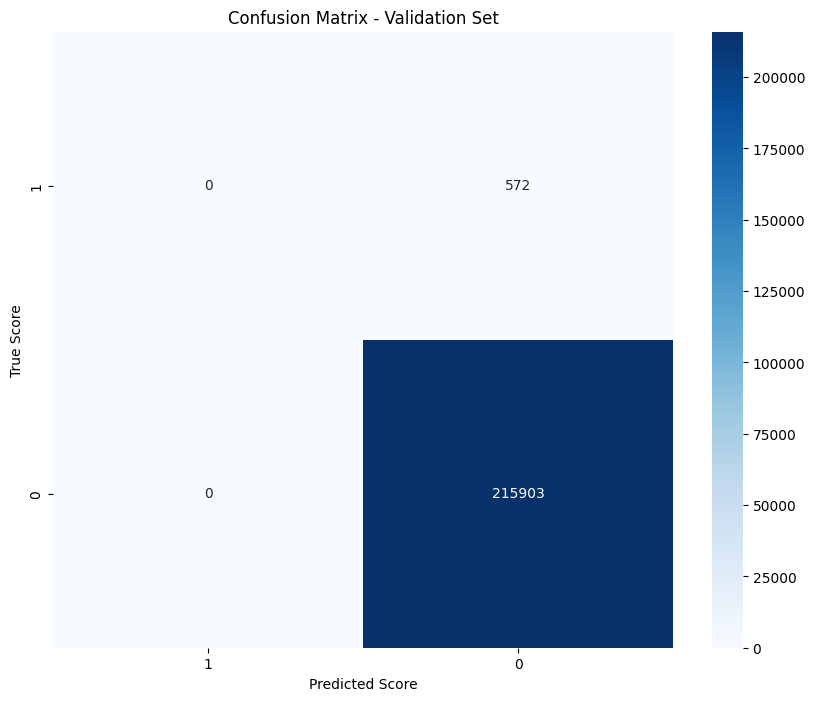


Evaluation complete!


In [15]:
# Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report


# Predict on training and validation sets
y_train_pred = model.predict(X_train_unscaled)
y_val_pred = model.predict(X_val_unscaled)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

train_f1 = f1_score(y_train, y_train_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

# Per-class F1 scores
per_class_f1 = f1_score(y_val, y_val_pred, average=None, labels=[1,0])

print("=" * 50)
print("MODEL EVALUATION")
print("=" * 50)
print(f"\nTraining Set:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  F1 Score (weighted): {train_f1:.4f}")

print(f"\nValidation Set:")
print(f"  Accuracy: {val_accuracy:.4f}")
print(f"  F1 Score (weighted): {val_f1:.4f}")

print(f"\nPer-class F1 Scores:")
for score, label in zip(per_class_f1, [1,0]):
    print(f"  Score {label}: {score:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, labels=[1,0]))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=[1,0])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Score')
plt.ylabel('True Score')
plt.show()

print("\nEvaluation complete!")